# Importing Libraries

In [1]:
#import all the libraries which may be needed
import numpy as np
import pandas as pd
import os
import random
from PIL import Image
import cv2
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow import keras
from tensorflow.keras import layers, models, optimizers
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Input, Dense, Flatten, GlobalAveragePooling2D
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from tensorflow.keras.optimizers import Adam

# Loading the Data

In [2]:
#first connect to google drive then take it from the correct folder

from google.colab import drive
drive.mount('/content/drive')

data_dir="/content/drive/MyDrive/Learningfuze/new_na_birds_dataset/Train"
test_dir="/content/drive/MyDrive/Learningfuze/new_na_birds_dataset/Test"
val_dir="/content/drive/MyDrive/Learningfuze/new_na_birds_dataset/Valid"

Mounted at /content/drive


Copying over Oystercatcher to rotate images

In [3]:
import os
import shutil
from PIL import Image

def oystercatcher(root_folder, rotation_degrees):

    if not os.path.isdir(root_folder):  #Gimini made me do this :(
        print(f"Folder '{root_folder}' not found  Nothing to see here")
        return

    for subfolder_name in os.listdir(root_folder):
        subfolder_path = os.path.join(root_folder, subfolder_name)

        if os.path.isdir(subfolder_path):
            print(f"Processing subfolder: {subfolder_name}")
            for filename in os.listdir(subfolder_path):
                file_path = os.path.join(subfolder_path, filename)

                if os.path.isfile(file_path) and filename.lower().endswith(('.png', '.jpg', '.jpeg', '.gif', '.bmp')):  #list all file formats
                    try:
                        # first, need to create a copy of the original image
                        new_filename = f"rotated_{filename}"
                        new_file_path = os.path.join(subfolder_path, new_filename)
                        shutil.copy2(file_path, new_file_path)  # copy2 preserves metadata

                        # Open the copied image created above and rotate it
                        img = Image.open(new_file_path)
                        rotated_img = img.rotate(rotation_degrees, expand=True) # expand=True to prevent cropping
                        rotated_img.save(new_file_path)

                        print(f"  - Copied and rotated: {filename} -> {new_filename}")

                    except Exception as e:
                        print(f"  - Error processing {filename}: Oystercatcher could not find anything {e}")

In [4]:
#oystercatcher(data_dir, 20)  #only use this if needed

In [5]:
#oystercatcher(test_dir, 20)

In [6]:
#oystercatcher(val_dir, 20)

In [7]:
def anti_oystercatcher(root_folder):  # to undo rotated images if they become problimatic or interfere with the training

    if not os.path.isdir(root_folder):  # nice to have
        print(f"Error: Folder '{root_folder}' not found.")
        return

    for subfolder_name in os.listdir(root_folder):
        subfolder_path = os.path.join(root_folder, subfolder_name)

        if os.path.isdir(subfolder_path):
            print(f"Processing subfolder: {subfolder_name}") #nice to have
            for filename in os.listdir(subfolder_path):
                file_path = os.path.join(subfolder_path, filename)
                if os.path.isfile(file_path) and filename.startswith("rotated_"):
                    try:
                        os.remove(file_path)
                        print(f"  - Deleted: {filename}")
                    except Exception as e:
                        print(f"  - Error deleting {filename}: {e}")

In [9]:
#anti_oystercatcher(data_dir)
#anti_oystercatcher(test_dir)
#anti_oystercatcher(val_dir)

#comment these out when done

Let's Create A function to show us some random images with thier labels

In [10]:
#create a function to generate a few random images

def pelican(main_folder, num_images):

  subfolders = [os.path.join(main_folder, f)
                  for f in os.listdir(main_folder)
                      if os.path.isdir(os.path.join(main_folder, f))]
  random.shuffle(subfolders)  # Randomize the order of subfolders so we have random results

  fig, axes = plt.subplots(nrows=1, ncols=num_images, figsize=(15, 5))
  for i, subfolder in enumerate(subfolders[:num_images]):
    image_paths = [os.path.join(subfolder, f) for f in os.listdir(subfolder) if f.lower().endswith(('.png', '.jpg', '.jpeg'))]
    random.shuffle(image_paths)  # Randomize the order of images within the subfolder so we get a random bird shown.  Hopefully it is a goldfinch
    image_path = image_paths[0]  # Select the first random image
    bird = os.path.basename(image_path)

    img = Image.open(image_path)
    axes[i].imshow(img)
    axes[i].axis('off')
    axes[i].set_title(bird, fontsize=10)  # Add label in title

  plt.tight_layout()
  plt.show()


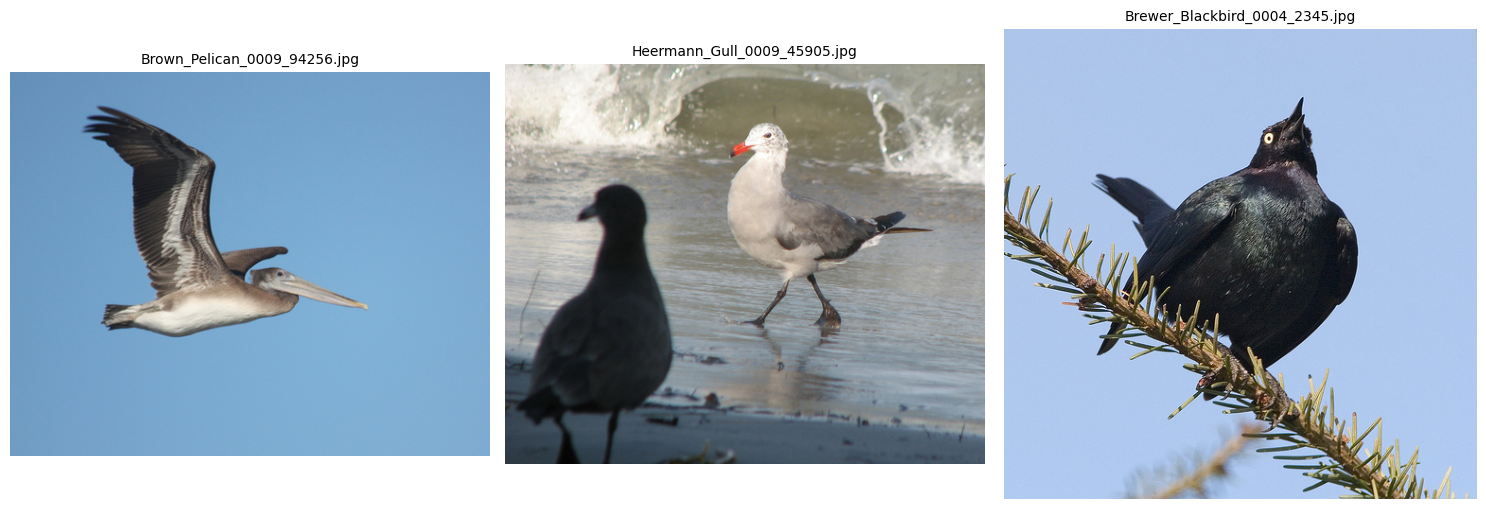

In [11]:
pelican('/content/drive/MyDrive/Learningfuze/new_na_birds_dataset/Test',3)

#scoreboard

#golfinch = 10pts
#pelcan = 8pts
#green jay = 7 pts
#seagull = -5 points
#house sparrow = automatic disqualification
#roadrunner = wildcard (up to 10pts)
#flicker = automatic win

#first to 20 pts wins


# Create an ImageDataGenerator for Training / Validating and Testing data

In [12]:
data = ImageDataGenerator( zoom_range=0.2,
                            width_shift_range=0.2,height_shift_range=0.2)

train_this = data.flow_from_directory(data_dir,
                                    class_mode = "categorical",
                                    target_size = (299, 299),
                                    batch_size = 32,
                                    shuffle = False,
                                    seed = 42)

Found 2570 images belonging to 50 classes.


In [13]:
data_val = ImageDataGenerator()
validate_this = data_val.flow_from_directory(val_dir,
                                      class_mode = "categorical",
                                      target_size = (299, 299),
                                      batch_size = 32,
                                      shuffle = False,
                                      seed = 42)
#this takes from the google drive files, does not shuffle them around and should have the file name as the category

Found 200 images belonging to 50 classes.


In [14]:
testing_this = data_val.flow_from_directory(test_dir,
                                      class_mode = "categorical",
                                      target_size = (299, 299),
                                      batch_size = 32,
                                      shuffle = False,
                                      seed = 42)

Found 208 images belonging to 50 classes.


# Use ResNet50 Model

In [15]:
from tensorflow.keras.applications import ResNet50  #opps, forgot to add this to the top row

# Load the ResNet50 model with base features only, not adding anything more to it
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(299, 299, 3))

# Freeze the pre-trained layers, keep these from updating and introducing more noise
for layer in base_model.layers:
  layer.trainable = False

# x marks the spot, or the model output
x = base_model.output
x = layers.GlobalAveragePooling2D()(x)
#outputs = layers.Dense(9, activation='softmax')(x)  # for the 7 species dataset + 2 more species
outputs = layers.Dense(50, activation='softmax')(x) # for the big 50 species dataset

# make the model using the ResNet50 set earlier
model = keras.Model(inputs=base_model.input, outputs=outputs)


94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


In [16]:
opt = Adam(learning_rate=0.001)
#use adam to optimize, .001 learning rate
model.compile(optimizer=opt, loss=keras.losses.categorical_crossentropy, metrics=['accuracy'])

In [17]:
history = model.fit(
      train_this,
      epochs=30,
      validation_data = validate_this)

/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/30
81/81 ━━━━━━━━━━━━━━━━━━━━ 1318s 16s/step - accuracy: 0.0024 - loss: 6.3365 - val_accuracy: 0.0550 - val_loss: 3.9086
Epoch 2/30
81/81 ━━━━━━━━━━━━━━━━━━━━ 57s 703ms/step - accuracy: 0.0481 - loss: 4.1048 - val_accuracy: 0.1450 - val_loss: 3.6413
Epoch 3/30
81/81 ━━━━━━━━━━━━━━━━━━━━ 57s 704ms/step - accuracy: 0.1551 - loss: 3.5681 - val_accuracy: 0.2600 - val_loss: 2.7985
Epoch 4/30
81/81 ━━━━━━━━━━━━━━━━━━━━ 57s 702ms/step - accuracy: 0.1933 - loss: 3.0213 - val_accuracy: 0.3500 - val_loss: 2.3920
Epoch 5/30
81/81 ━━━━━━━━━━━━━━━━━━━━ 57s 701ms/step - accuracy: 0.2739 - loss: 2.5737 - val_accuracy: 0.4350 - val_loss: 2.0630
Epoch 6/30
81/81 ━━━━━━━━━━━━━━━━━━━━ 57s 698ms/step - accuracy: 0.4581 - loss: 1.9746 - val_accuracy: 0.5050 - val_loss: 1.8495
Epoch 7/30
81/81 ━━━━━━━━━━━━━━━━━━━━ 57s 702ms/step - accuracy: 0.4416 - loss: 1.9744 - val_accuracy: 0.4750 - val_loss: 1.8673
Epoch 8/30
81/81 ━━━━━━━━━━━━━━━━━━━━ 57s 702ms/step - accuracy: 0.4793 - loss: 1.7745 - val_accu

# Plotting Our Metrics

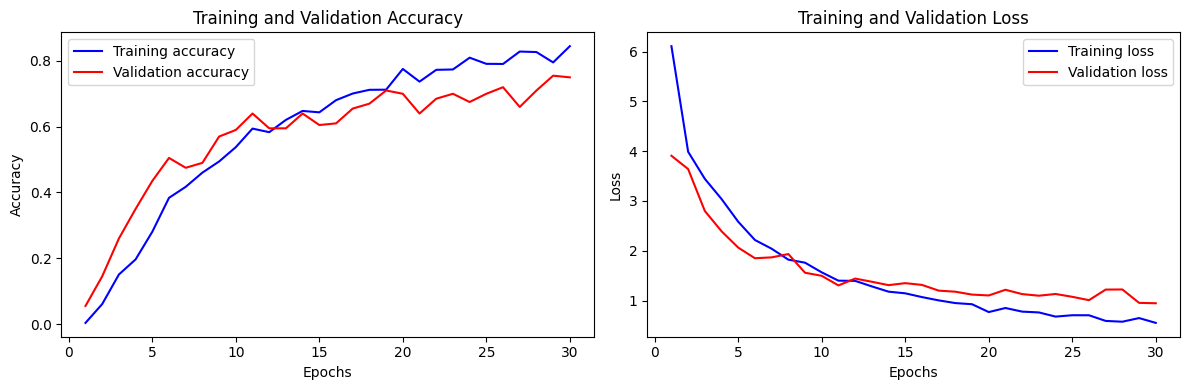

In [18]:
    # Extracting training and validation metrics from the history object
    train_acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    train_loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs = range(1, len(train_acc) + 1)

    # Plotting accuracy
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.plot(epochs, train_acc, 'b', label='Training accuracy')
    plt.plot(epochs, val_acc, 'r', label='Validation accuracy')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    # Plotting loss
    plt.subplot(1, 2, 2)
    plt.plot(epochs, train_loss, 'b', label='Training loss')
    plt.plot(epochs, val_loss, 'r', label='Validation loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.tight_layout()
    plt.show()

# Evaluating the model's performance on the test dataset.

In [19]:
predictions=model.evaluate(testing_this)

7/7 ━━━━━━━━━━━━━━━━━━━━ 67s 11s/step - accuracy: 0.7232 - loss: 0.7288


In [22]:
# Get true labels
true_labels = testing_this.classes

# Use the model to predict the classes
predicted_labels = np.argmax(model.predict(test_dir), axis=1)

# Display classification report
print("Classification Report:\n", classification_report(true_labels, predicted_labels, target_names=test_dir.class_indices.keys()))

ValueError: Unrecognized data type: x=/content/drive/MyDrive/Learningfuze/new_na_birds_dataset/Test (of type <class 'str'>)